In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import AdamW, lr_scheduler
import pytorch_lightning as pl
from torchvision import models
import torch_pruning as tp
import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import networkx as nx
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset

# Set MPS as the default device
torch.set_default_device("mps")

In [2]:
class AlexNetFineTuner(pl.LightningModule):
    def __init__(self, learning_rate=1e-4, num_classes=10):
        super(AlexNetFineTuner, self).__init__()
        self.save_hyperparameters()

        # Load pre-trained AlexNet
        self.model = models.alexnet(pretrained=False)
        self.model.classifier[6] = torch.nn.Linear(4096, num_classes)  # Update the classifier layer

        # Initialize metrics dictionary
        self.metrics = {
            "pruning_percentage": [],
            "test_accuracy": [],
            "test_loss": [],
            "model_size": []
        }
        
        self.test_outputs = []
    def forward(self, x):
        return self.model(x)

    def print_dependency_graph(self, DG):
        print("\nDependency Graph Details:")
        for module, node in DG.module2node.items():
            print(f"Module: {module}")
            for dep in node.dependencies:
                print(f"    * Target Module: {dep.target.module}")

    def visualize_dependency_graph(self, DG):
        """Visualize the dependency graph using networkx."""
        G = nx.DiGraph()
        for module, node in DG.module2node.items():
            for dep in node.dependencies:
                G.add_edge(str(module), str(dep.target.module))
        plt.figure(figsize=(12, 8))
        nx.draw(G, with_labels=True, node_size=1000, font_size=8, node_color="skyblue", edge_color="gray")
        plt.title("Dependency Graph")
        plt.show()

    # def prune_model(self, pruning_percentage=0.2):
    #     # example_inputs = torch.randn(1, 3, 224, 224)  # Example input for dependency graph
    #     example_inputs = torch.randn(1, 3, 224, 224, dtype=torch.float32).to("mps")
    #     imp = tp.importance.TaylorImportance()

    #     ignored_layers = []
    #     for m in model.modules():
    #         if isinstance(m, torch.nn.Linear) and m.out_features == 1000:
    #             ignored_layers.append(m) # DO NOT prune the final classifier!

    #     iterative_steps = 5 # progressive pruning
    #     pruner = tp.pruner.MagnitudePruner(
    #         model,
    #         example_inputs,
    #         importance=imp,
    #         iterative_steps=iterative_steps,
    #         ch_sparsity=0.5, # remove 50% channels, ResNet18 = {64, 128, 256, 512} => ResNet18_Half = {32, 64, 128, 256}
    #         ignored_layers=ignored_layers,
    #     )
        
    #     self.model = self.model.to("mps")
    #     self.model = self.model.to(torch.float32)

    #     print("MODEL BEFORE PRUNING --------------------->", self.model)

    #     DG = tp.DependencyGraph().build_dependency(self.model, example_inputs)
    #     self.print_dependency_graph(DG)
    #     self.visualize_dependency_graph(DG)

    #     # Choose a layer to prune
    #     layer_to_prune = self.model.classifier[1]

    #     # Prune layer
    #     num_features = layer_to_prune.out_features
    #     pruning_idxs = torch.arange(0, int(num_features * pruning_percentage)).tolist()
    #     group = DG.get_pruning_group(layer_to_prune, tp.prune_linear_out_channels, idxs=pruning_idxs)
    #     if DG.check_pruning_group(group):
    #         group.prune()

    #     print("MODEL AFTER PRUNING --------------------->", self.model)
    #     print("PRUNING GROUP ---------------------->", group)

    #     all_groups = list(DG.get_all_groups())
    #     print("Number of Groups: --------------------->%d"%len(all_groups))
    #     print("The last Group: --------------------->", all_groups[-1])
    #     # Update metrics after pruning
    #     self.metrics["model_size"].append(sum(p.numel() for p in self.model.parameters() if p.requires_grad))
    #     self.metrics["pruning_percentage"].append(pruning_percentage * 100)

    def high_level_prune_model(self, ch_sparsity=0.5, iterative_steps=5):
        example_inputs = torch.randn(1, 3, 224, 224, dtype=torch.float32).to("mps")
        print("Example inputs device and dtype:------------------------", example_inputs.device, example_inputs.dtype)

        print(f"Model device-------------------: {next(self.model.parameters()).device}, dtype: {next(self.model.parameters()).dtype}")
        self.model = self.model.to("mps").to(torch.float32)
        print(f"Model device-------------------: {next(self.model.parameters()).device}, dtype: {next(self.model.parameters()).dtype}")

        # Define importance criteria
        imp = tp.importance.TaylorImportance()

        # Specify ignored layers (e.g., the final classification layer)
        ignored_layers = []
        for m in self.model.modules():
            if isinstance(m, torch.nn.Linear) and m.out_features == 10:  # Adjust for your dataset
                ignored_layers.append(m)

        # Initialize high-level pruner
        pruner = tp.pruner.MagnitudePruner(
            self.model,
            example_inputs,
            importance=imp,
            iterative_steps=iterative_steps,
            ch_sparsity=ch_sparsity,
            ignored_layers=ignored_layers,
        )

        # Count operations and parameters before pruning
        base_macs, base_nparams = tp.utils.count_ops_and_params(self.model, example_inputs)
        print(f"Before pruning: MACs={base_macs}, Params={base_nparams}")

        # Iteratively prune and update metrics
        for i in range(iterative_steps):
            print(f"Pruning step {i + 1}/{iterative_steps}...")

            # If using TaylorImportance, calculate gradients
            if isinstance(imp, tp.importance.TaylorImportance):
                loss = self.model(example_inputs).sum()  # Dummy loss
                loss.backward()  # Backpropagate to calculate gradients

            # Prune the model
            pruner.step()

            # Recalculate MACs and parameters
            macs, nparams = tp.utils.count_ops_and_params(self.model, example_inputs)
            print(f"After step {i + 1}: MACs={macs}, Params={nparams}")

            # Append metrics once per pruning step
            self.metrics["model_size"].append(nparams)
            self.metrics["pruning_percentage"].append(ch_sparsity * 100 * (i + 1) / iterative_steps)

            # Optional: Fine-tune the model here
            # self.fine_tune_model()  # Add fine-tuning code if needed

        print("Pruning complete.")


    def training_step(self, batch, batch_idx):
        images, labels = batch
        images = images.to(torch.float32)  # Convert inputs to float32
        labels = labels.to("mps")  # Ensure labels are on MPS

        print("Images device and dtype:---------------------", images.device, images.dtype)
        print("Labels device and dtype:", labels.device, labels.dtype)

        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        images = images.to(torch.float32)  # Convert inputs to float32
        labels = labels.to("mps")  # Ensure labels are on MPS
        outputs = self(images)
        val_loss = F.cross_entropy(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        val_acc = (preds == labels).float().mean()
        self.log("val_loss", val_loss, prog_bar=True)
        self.log("val_acc", val_acc, prog_bar=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        images = images.to(torch.float32)
        labels = labels.to("mps")
        outputs = self(images)
        test_loss = F.cross_entropy(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        test_acc = (preds == labels).float().mean()

        # Store batch results for aggregation later
        self.test_outputs.append({"test_loss": test_loss.item(), "test_acc": test_acc.item()})

        # Log per-batch results if needed
        self.log("test_loss_batch", test_loss, prog_bar=True)
        self.log("test_acc_batch", test_acc, prog_bar=True)

        return test_loss

    def on_test_epoch_end(self):
        # Aggregate metrics across batches
        avg_loss = sum(o["test_loss"] for o in self.test_outputs) / len(self.test_outputs)
        avg_acc = sum(o["test_acc"] for o in self.test_outputs) / len(self.test_outputs)

        # Append aggregated metrics for the epoch
        self.metrics["test_accuracy"].append(avg_acc)
        self.metrics["test_loss"].append(avg_loss)

        # Log aggregated metrics
        self.log("test_loss_epoch", avg_loss, prog_bar=True)
        self.log("test_acc_epoch", avg_acc, prog_bar=True)

        # Clear outputs for the next test epoch
        self.test_outputs = []


    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss"}}



In [3]:
def plot_metrics(metrics):
    print("----------------------->1", metrics["pruning_percentage"], metrics["test_accuracy"])
    print("----------------------->2", metrics["pruning_percentage"], metrics["test_loss"])
    print("----------------------->2", metrics["pruning_percentage"], metrics["model_size"])

    plt.figure()
    plt.plot(metrics["pruning_percentage"], metrics["test_accuracy"], marker='o', label="Accuracy")
    plt.title("Test Accuracy vs. Pruning Percentage")
    plt.xlabel("Pruning Percentage (%)")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(metrics["pruning_percentage"], metrics["test_loss"], marker='o', color="orange", label="Loss")
    plt.title("Test Loss vs. Pruning Percentage")
    plt.xlabel("Pruning Percentage (%)")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(metrics["pruning_percentage"], metrics["model_size"], marker='o', color="green", label="Model Size")
    plt.title("Model Size vs. Pruning Percentage")
    plt.xlabel("Pruning Percentage (%)")
    plt.ylabel("Number of Parameters")
    plt.grid(True)
    plt.legend()
    plt.show()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: p-mangal (p-mangal-university-of-amsterdam). Use `wandb login --relogin` to force relogin


Files already downloaded and verified
Files already downloaded and verified


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_pruning/pruner/algorithms/metapruner.py:90: UserWarning: ch_sparsity is deprecated in v1.3.0. Please use pruning_ratio.
  warnings.warn("ch_sparsity is deprecated in v1.3.0. Please use pruning_ratio.")


Model device-------------------: mps:0, dtype: torch.float32
Applying 0% pruning...
Example inputs device and dtype:------------------------ mps:0 torch.float32
Model device-------------------: mps:0, dtype: torch.float32
Model device-------------------: mps:0, dtype: torch.float32
Before pruning: MACs=711505866.0, Params=57044810
Pruning step 1/5...
After step 1: MACs=578047534.0, Params=46142053
Pruning step 2/5...
After step 2: MACs=464127435.0, Params=36405884
Pruning step 3/5...
After step 3: MACs=359767251.0, Params=27936552
Pruning step 4/5...
After step 4: MACs=271142930.0, Params=20488673
Pruning step 5/5...


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


After step 5: MACs=195799018.0, Params=14279594
Pruning complete.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_batch       │    0.11999999731779099    │
│      test_acc_epoch       │          0.09375          │
│      test_loss_batch      │     3.400278329849243     │
│      test_loss_epoch      │    3.3885245323181152     │
└───────────────────────────┴───────────────────────────┘

Applying 10.0% pruning...
Example inputs device and dtype:------------------------ mps:0 torch.float32
Model device-------------------: cpu, dtype: torch.float32
Model device-------------------: mps:0, dtype: torch.float32
Before pruning: MACs=195799018.0, Params=14279594
Pruning step 1/5...
After step 1: MACs=158985251.0, Params=11549848
Pruning step 2/5...
After step 2: MACs=128582158.0, Params=9113221
Pruning step 3/5...
After step 3: MACs=101998898.0, Params=6966689
Pruning step 4/5...
After step 4: MACs=77937995.0, Params=5106492
Pruning step 5/5...


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


After step 5: MACs=57911034.0, Params=3579098
Pruning complete.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_batch       │    0.11999999731779099    │
│      test_acc_epoch       │         0.1484375         │
│      test_loss_batch      │    2.9491405487060547     │
│      test_loss_epoch      │    3.0298569202423096     │
└───────────────────────────┴───────────────────────────┘

Applying 20.0% pruning...
Example inputs device and dtype:------------------------ mps:0 torch.float32
Model device-------------------: cpu, dtype: torch.float32
Model device-------------------: mps:0, dtype: torch.float32
Before pruning: MACs=57911034.0, Params=3579098
Pruning step 1/5...
After step 1: MACs=47418242.0, Params=2876225
Pruning step 2/5...
After step 2: MACs=38180211.0, Params=2284552
Pruning step 3/5...
After step 3: MACs=31376235.0, Params=1732524
Pruning step 4/5...
After step 4: MACs=23814910.0, Params=1280917
Pruning step 5/5...


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


After step 5: MACs=18958402.0, Params=899378
Pruning complete.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_batch       │    0.10000000149011612    │
│      test_acc_epoch       │         0.078125          │
│      test_loss_batch      │    2.6466357707977295     │
│      test_loss_epoch      │    2.7109122276306152     │
└───────────────────────────┴───────────────────────────┘

Applying 30.0% pruning...
Example inputs device and dtype:------------------------ mps:0 torch.float32
Model device-------------------: cpu, dtype: torch.float32
Model device-------------------: mps:0, dtype: torch.float32
Before pruning: MACs=18958402.0, Params=899378
Pruning step 1/5...
After step 1: MACs=15593195.0, Params=713172
Pruning step 2/5...
After step 2: MACs=12831826.0, Params=566113
Pruning step 3/5...
After step 3: MACs=10119498.0, Params=435561
Pruning step 4/5...
After step 4: MACs=7769051.0, Params=322432
Pruning step 5/5...


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


After step 5: MACs=6979926.0, Params=227150
Pruning complete.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_batch       │    0.10000000149011612    │
│      test_acc_epoch       │         0.078125          │
│      test_loss_batch      │     2.383073568344116     │
│      test_loss_epoch      │    2.4033541679382324     │
└───────────────────────────┴───────────────────────────┘

Applying 40.0% pruning...
Example inputs device and dtype:------------------------ mps:0 torch.float32
Model device-------------------: cpu, dtype: torch.float32
Model device-------------------: mps:0, dtype: torch.float32
Before pruning: MACs=6979926.0, Params=227150
Pruning step 1/5...
After step 1: MACs=5146252.0, Params=179791
Pruning step 2/5...
After step 2: MACs=4808715.0, Params=138908
Pruning step 3/5...
After step 3: MACs=3290361.0, Params=110082
Pruning step 4/5...
After step 4: MACs=3036458.0, Params=78689
Pruning step 5/5...


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


After step 5: MACs=2865148.0, Params=57944
Pruning complete.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_batch       │    0.10000000149011612    │
│      test_acc_epoch       │         0.078125          │
│      test_loss_batch      │     2.321596622467041     │
│      test_loss_epoch      │    2.3259541988372803     │
└───────────────────────────┴───────────────────────────┘

Applying 50.0% pruning...
Example inputs device and dtype:------------------------ mps:0 torch.float32
Model device-------------------: cpu, dtype: torch.float32
Model device-------------------: mps:0, dtype: torch.float32
Before pruning: MACs=2865148.0, Params=57944
Pruning step 1/5...
After step 1: MACs=1519631.0, Params=45634
Pruning step 2/5...
After step 2: MACs=1422646.0, Params=35293
Pruning step 3/5...
After step 3: MACs=1368641.0, Params=26378
Pruning step 4/5...
After step 4: MACs=1290935.0, Params=18684
Pruning step 5/5...


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


After step 5: MACs=1276374.0, Params=15068
Pruning complete.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_batch       │    0.07999999821186066    │
│      test_acc_epoch       │          0.0625           │
│      test_loss_batch      │     2.306103467941284     │
│      test_loss_epoch      │     2.307271957397461     │
└───────────────────────────┴───────────────────────────┘

----------------------->1 [10.0, 20.0, 30.0, 40.0, 50.0, 10.0, 20.0, 30.0, 40.0, 50.0, 10.0, 20.0, 30.0, 40.0, 50.0, 10.0, 20.0, 30.0, 40.0, 50.0, 10.0, 20.0, 30.0, 40.0, 50.0, 10.0, 20.0, 30.0, 40.0, 50.0] [0.09375, 0.1484375, 0.078125, 0.078125, 0.078125, 0.0625]
----------------------->2 [10.0, 20.0, 30.0, 40.0, 50.0, 10.0, 20.0, 30.0, 40.0, 50.0, 10.0, 20.0, 30.0, 40.0, 50.0, 10.0, 20.0, 30.0, 40.0, 50.0, 10.0, 20.0, 30.0, 40.0, 50.0, 10.0, 20.0, 30.0, 40.0, 50.0] [3.3885245323181152, 3.029856860637665, 2.7109121084213257, 2.403354287147522, 2.3259541988372803, 2.307271957397461]
----------------------->2 [10.0, 20.0, 30.0, 40.0, 50.0, 10.0, 20.0, 30.0, 40.0, 50.0, 10.0, 20.0, 30.0, 40.0, 50.0, 10.0, 20.0, 30.0, 40.0, 50.0, 10.0, 20.0, 30.0, 40.0, 50.0, 10.0, 20.0, 30.0, 40.0, 50.0] [46142053, 36405884, 27936552, 20488673, 14279594, 11549848, 9113221, 6966689, 5106492, 3579098, 2876225, 2284552, 1732524, 1280917, 899378, 713172, 566113, 435561, 322432, 227150, 179791, 138908, 11008

ValueError: x and y must have same first dimension, but have shapes (30,) and (6,)

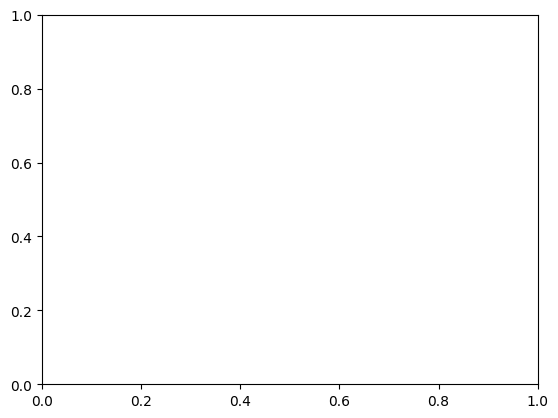

In [4]:
def main():
    wandb.init(project='alexnet_depGraph', name='AlexNet_Run')
    wandb_logger = WandbLogger(log_model=False)

    transform = Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_dataset = Subset(CIFAR10(root='./data', train=True, download=True, transform=transform), range(500))
    test_dataset = Subset(CIFAR10(root='./data', train=False, download=True, transform=transform), range(100))
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=32)

    checkpoint_path = "../checkpointsAlex/best-checkpoint.ckpt"
    model = AlexNetFineTuner.load_from_checkpoint(checkpoint_path)
    model = model.to(torch.float32)
    for param in model.parameters():
        param.data = param.data.to(torch.float32).to("mps")
        if param.grad is not None:
            param.grad = param.grad.to(torch.float32).to("mps")

    print(f"Model device-------------------: {next(model.parameters()).device}, dtype: {next(model.parameters()).dtype}")

    pruning_percentages = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
    for pruning_percentage in pruning_percentages:
        print(f"Applying {pruning_percentage * 100}% pruning...")
        model.high_level_prune_model(ch_sparsity=0.5, iterative_steps=5)
        trainer = pl.Trainer(logger=wandb_logger)
        trainer.test(model, dataloaders=test_dataloader)

    plot_metrics(model.metrics)
    wandb.finish()


if __name__ == "__main__":
    main()